### Imports 👽

In [1]:
import os, sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import math
import numpy as np

sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from data_classes.enums import Scenario, SamplingMethod

### Prepare Data to Compare ⚙️

In [2]:
scenario = Scenario.SUM_SINES

output_dir = os.path.abspath(os.path.join('..', 'data', scenario.value, 'output'))

sampling_types = [SamplingMethod.SOBOL, SamplingMethod.MC]
epochs_types = [1000]

dfs = []
for sampling_type in sampling_types:
    for epochs in epochs_types:
        df = pd.read_csv(os.path.join(output_dir, f'{sampling_type.value}_{epochs}epochs_results.csv'))
        df['epochs'] = epochs
        df['sampling_type'] = sampling_type.value
        dfs.append(df)

together_df = pd.concat(dfs, ignore_index=True)
together_df.to_csv(os.path.join(output_dir, 'together.csv'), index=False)

### Analysis 📊

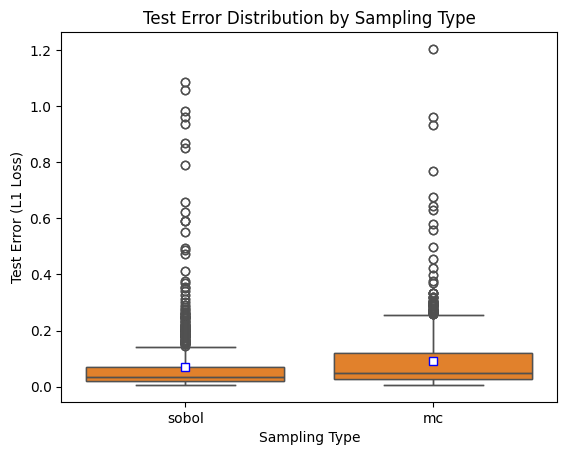

In [3]:
sns.boxplot(data=together_df, x="sampling_type", y="test_error")
sns.boxplot(data=together_df, x="sampling_type", y="test_error", showmeans=True,
            meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"})

plt.title("Test Error Distribution by Sampling Type")
plt.ylabel("Test Error (L1 Loss)")
plt.xlabel("Sampling Type")
plt.show()

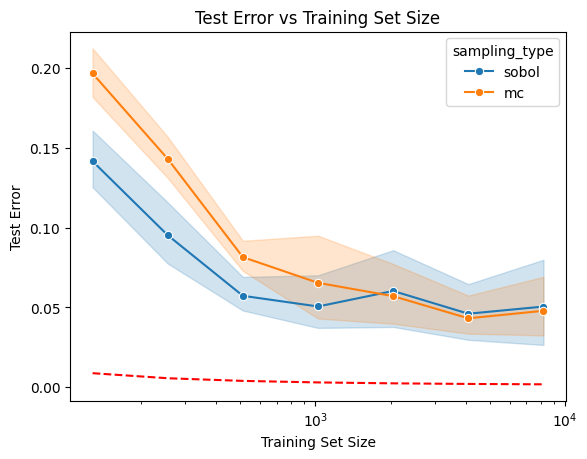

In [ ]:
sns.lineplot(
    data=together_df,
    x="train_size",
    y="test_error",
    hue="sampling_type",
    marker="o"
)
x_vals = np.array(sorted(together_df['train_size'].unique()), dtype=float)
def diff_func(x):
    return np.sqrt(x)/np.log(x)**6
y_vals = diff_func(x_vals)
plt.plot(x_vals, 30*y_vals, label='y = sqrt(x) / log(x)^6', color='red', linestyle='--')
plt.title("Test Error vs Training Set Size")
plt.ylabel("Test Error")
plt.xlabel("Training Set Size")
plt.xscale("log")  # if sizes vary exponentially
plt.show()


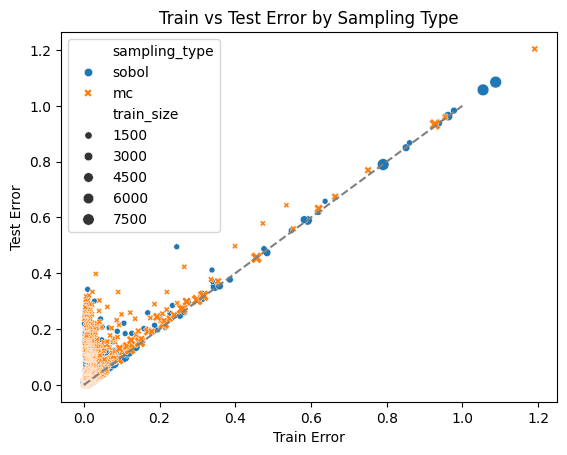

In [5]:
sns.scatterplot(
    data=together_df,
    x="train_error",
    y="test_error",
    hue="sampling_type",
    style="sampling_type",
    size="train_size"
)
plt.title("Train vs Test Error by Sampling Type")
plt.plot([0, 1], [0, 1], ls="--", c="gray")  # identity line
plt.xlabel("Train Error")
plt.ylabel("Test Error")
plt.show()


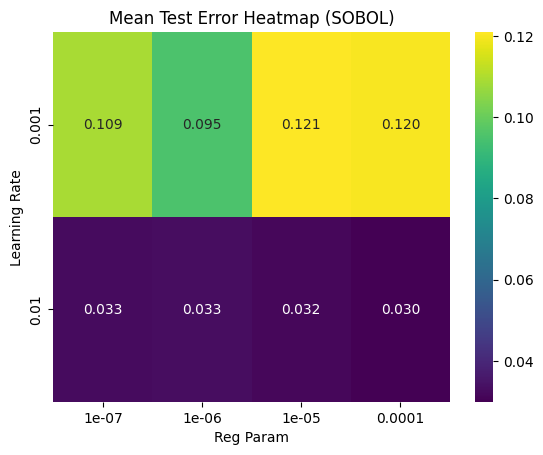

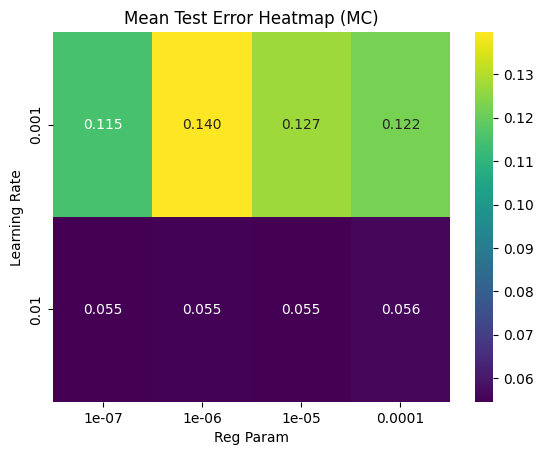

In [6]:
for method in ["sobol", "mc"]:
    pivot = together_df[together_df["sampling_type"] == method].pivot_table(
        index="learning_rate",
        columns="reg_param",
        values="test_error",
        aggfunc="mean"
    )
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
    plt.title(f"Mean Test Error Heatmap ({method.upper()})")
    plt.ylabel("Learning Rate")
    plt.xlabel("Reg Param")
    plt.show()


In [7]:
together_df.loc[(together_df.depth == 4) & (together_df.sampling_type == 'sobol')]

,learning_rate,reg_param,batch_norm,depth,num_hidden_layers,activation,train_error,test_error,train_size,optim_time,epochs,sampling_type
264,0.010,1.000000e-06,True,4,6,Sigmoid,0.023412,0.024049,8192,4,1000,sobol
274,0.010,1.000000e-07,True,4,12,Sigmoid,0.023327,0.024570,8192,7,1000,sobol
277,0.010,1.000000e-04,True,4,6,Sigmoid,0.024343,0.024986,8192,4,1000,sobol
282,0.010,1.000000e-04,True,4,6,Sigmoid,0.025080,0.025147,4096,2,1000,sobol
284,0.010,1.000000e-04,True,4,12,Sigmoid,0.023170,0.025214,1024,2,1000,sobol
...,...,...,...,...,...,...,...,...,...,...,...,...
835,0.001,1.000000e-07,True,4,12,Sigmoid,0.936800,0.937655,2048,3,1000,sobol
836,0.001,1.000000e-04,True,4,12,Sigmoid,0.962301,0.962884,4096,5,1000,sobol
837,0.001,1.000000e-05,True,4,12,Sigmoid,0.977703,0.983043,1024,2,1000,sobol
838,0.001,1.000000e-07,True,4,24,Sigmoid,1.054532,1.057153,8192,15,1000,sobol


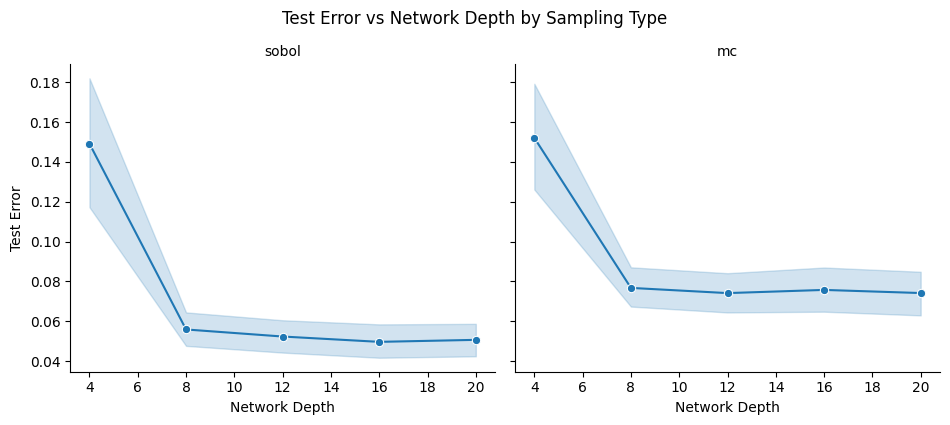

In [8]:
g = sns.FacetGrid(
    together_df, col="sampling_type", height=4, aspect=1.2
)
g.map_dataframe(sns.lineplot, x="depth", y="test_error", marker="o")
g.set_axis_labels("Network Depth", "Test Error")
g.set_titles(col_template="{col_name}")
plt.suptitle("Test Error vs Network Depth by Sampling Type", y=1.05)
plt.show()


In [9]:
model = smf.ols('test_error ~ sampling_type + train_size + reg_param + learning_rate', data=together_df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             test_error   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     83.45
Date:                Wed, 13 Aug 2025   Prob (F-statistic):           1.11e-64
Time:                        15:20:43   Log-Likelihood:                 1437.1
No. Observations:                1680   AIC:                            -2864.
Df Residuals:                    1675   BIC:                            -2837.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0